<a href="https://colab.research.google.com/github/marciliojrr/PDI/blob/main/%5CProjeto%20Final%5CPDI_Projeto_final_Img2MIDI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Atualizando dependência para usar paralelismo ao usar o @jit.
# Updating dependencies to use parallelism when using @jit.
!pip install --upgrade tbb
!pip install pychord
!pip install pretty_midi

# Importando dependênias.
# Importing dependencies.

import matplotlib.pyplot as plt
import numpy as np
from numpy import pi, sqrt, cos, log10, log, arccos
from PIL import Image
from numba import jit
from pychord import Chord
import pretty_midi

#import soundfile as sf
#from IPython.display import Audio


'''
Alguns métodos entrarão em desuso e precisarão ser implementados novamente.
Neste momento, esses avisos estão aparecendo na função "comp_change()".
Some methods will fall out of favor and will need to be implemented again.
Right now, these warnings are showing up in the "comp_change()" function.
'''
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [55]:
def show_image(image, figsize=[5, 5]):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.show()


def plot(audio, figsize=[5, 5], color="blue", y_label="Amplitude", stroke=0.5, title=""):
    plt.figure('audio', figsize=figsize)
    plt.plot(audio, linewidth=stroke, alpha=1, color=color)
    plt.title(title)
    plt.ylabel(y_label)
    plt.show()


def input_image(image):
    img = Image.open(image).convert('L')
    img = img.resize((8, 8), Image.ANTIALIAS)
    
    show_image(img)

    return img


@jit(nopython=True, parallel=True)
def dct1d(x):
    N = x.size
    two_N = 2.0 * N
    two_pi = 2.0 * pi
    root_two_over_N = sqrt(2 / N)
    one_over_root_N = 1 / sqrt(N)
    X = np.zeros(N)

    for k in range(N):
        ck = one_over_root_N if k == 0 else root_two_over_N
        accumulator = 0
        for n in range(N):
            accumulator += x[n] * cos((two_pi * (k / (two_N) * n)) + ((k * pi) / (two_N)))
        X[k] = ck * accumulator

    return X


def dct2d_sep(image):
    image = np.asarray(img)
    imgDCT = np.zeros(image.shape)
    for i, line in enumerate(image):
        imgDCT[i] = dct1d(line)
    imgDCT = imgDCT.T
    for i, line in enumerate(imgDCT):
        imgDCT[i] = dct1d(line)    
        imgDCT = imgDCT.T

    show_image(imgDCT)

    return #imgDCT


def filter(x, opt=2):
    dct_filter = np.asarray(imgDCT)
    if opt == 1:
        for i in range(0, len(x)):
            for j in range(0, len(x)):
                if x[i][j] > 0 or x[i][j] < 264:
                    np.append(dct_filter, x[i][j])
        for i in range(0, len(dct_filter)):
            for j in range(0, len(dct_filter)):
                if dct_filter[i][j] < 0:
                    dct_filter[i][j] = abs(dct_filter[i][j])

    elif opt == 2:
        for i in range(0, len(dct_filter)):
            for j in range(0, len(dct_filter)):
                if dct_filter[i][j] < 0:
                    dct_filter[i][j] = abs(dct_filter[i][j])

    return dct_filter


@jit(nopython=True, parallel=True)
def create_midi(chords):
    midi_data = pretty_midi.PrettyMIDI()
    
    piano_program = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
    piano = pretty_midi.Instrument(program=piano_program)
    
    guitar_harm_program = pretty_midi.instrument_name_to_program('Guitar harmonics')
    guitar_harm = pretty_midi.Instrument(program=guitar_harm_program)

    contrabass_program = pretty_midi.instrument_name_to_program('Contrabass')
    contrabass = pretty_midi.Instrument(program=contrabass_program)

    sax_program = pretty_midi.instrument_name_to_program('Soprano Sax')
    sax = pretty_midi.Instrument(program=sax_program)

    breath_program = pretty_midi.instrument_name_to_program('Breath Noise')
    breath = pretty_midi.Instrument(program=breath_program)

    seashore_program = pretty_midi.instrument_name_to_program('Seashore')
    seashore = pretty_midi.Instrument(program=seashore_program)

    voice_program = pretty_midi.instrument_name_to_program('Voice Oohs')
    voice = pretty_midi.Instrument(program=voice_program)


    length = 1
    
    for n, chord in enumerate(chords):
        for note_name in chord.components_with_pitch(root_pitch=2):
            note_number = pretty_midi.note_name_to_number(note_name)
            
            note_piano = pretty_midi.Note(velocity=100, pitch=note_number, start=n * length, end=(n + 1) * length)
            
            piano.notes.append(note_piano)
    
    for n, chord in enumerate(chords):
        for note_name in chord.components_with_pitch(root_pitch=4):
            note_number = pretty_midi.note_name_to_number(note_name)

            note_guitar_harm = pretty_midi.Note(velocity=100, pitch=note_number, start=n * length, end=(n + 1) * length)

            guitar_harm.notes.append(note_guitar_harm) 

    for n, chord in enumerate(chords):
        for note_name in chord.components_with_pitch(root_pitch=0):
            note_number = pretty_midi.note_name_to_number(note_name)

            note_contrabass = pretty_midi.Note(velocity=125, pitch=note_number, start=n * length, end=(n + 1) * length)

            contrabass.notes.append(note_contrabass)
    
    for n, chord in enumerate(chords):
        for note_name in chord.components_with_pitch(root_pitch=5):
            note_number = pretty_midi.note_name_to_number(note_name)

            note_sax = pretty_midi.Note(velocity=125, pitch=note_number, start=n * length, end=(n + 1) * length)

            sax.notes.append(note_sax)

    for n, chord in enumerate(chords):
        for note_name in chord.components_with_pitch(root_pitch=5):
            note_number = pretty_midi.note_name_to_number(note_name)

            note_breath = pretty_midi.Note(velocity=100, pitch=note_number, start=n * length, end=(n + 1) * length)

            breath.notes.append(note_breath)

    
    for n, chord in enumerate(chords):
        for note_name in chord.components_with_pitch(root_pitch=4):
            note_number = pretty_midi.note_name_to_number(note_name)

            note_seashore = pretty_midi.Note(velocity=100, pitch=note_number, start=n * length, end=(n + 1) * length)

            seashore.notes.append(note_seashore)


    for n, chord in enumerate(chords):
        for note_name in chord.components_with_pitch(root_pitch=5):
            note_number = pretty_midi.note_name_to_number(note_name)

            note_voice = pretty_midi.Note(velocity=100, pitch=note_number, start=n * length, end=(n + 1) * length)

            voice.notes.append(note_voice)


    midi_data.instruments.append(piano)
    midi_data.instruments.append(guitar_harm)
    midi_data.instruments.append(contrabass)
    midi_data.instruments.append(sax)
    midi_data.instruments.append(breath)
    midi_data.instruments.append(seashore)
    midi_data.instruments.append(voice)

    midi_data.write('img_to_midi.mid')


@jit(nopython=True, parallel=True)
def create_chords(img_to_midi):
    aux = []
    for i in range(0, len(img_to_midi)):
        for j in range(0, len(img_to_midi)):
            if img_to_midi[i][j] >= 0.0 and img_to_midi[i][j] < 10.00:
                aux_chord = 'E7'
            elif img_to_midi[i][j] >= 10.00 and img_to_midi[i][j] < 15.00:
                aux_chord = 'Eb'
            elif img_to_midi[i][j] >= 15.00 and img_to_midi[i][j] < 20.00:
                aux_chord = 'F'
            elif img_to_midi[i][j] >= 20.00 and img_to_midi[i][j] < 25.00:
                aux_chord = 'Gb'
            elif img_to_midi[i][j] >= 25.00 and img_to_midi[i][j] < 30.00:
                aux_chord = 'Ab'
            elif img_to_midi[i][j] >= 35.00 and img_to_midi[i][j] < 40.00:
                aux_chord = 'C'
            elif img_to_midi[i][j] >= 45.00 and img_to_midi[i][j] < 50.00:
                aux_chord = 'C#'
            elif img_to_midi[i][j] >= 50.00 and img_to_midi[i][j] < 55.00:
                aux_chord = 'D'
            elif img_to_midi[i][j] >= 55.00 and img_to_midi[i][j] < 60.00:
                aux_chord = 'D#'
            elif img_to_midi[i][j] >= 60.00 and img_to_midi[i][j] < 70.00:
                aux_chord = 'E'
            elif img_to_midi[i][j] >= 70.00 and img_to_midi[i][j] < 80.00:
                aux_chord = 'B'
            elif img_to_midi[i][j] >= 80.00 and img_to_midi[i][j] < 90.00:
                aux_chord = 'F#'
            elif img_to_midi[i][j] >= 90.00 and img_to_midi[i][j] < 100.00:
                aux_chord = 'G'
            elif img_to_midi[i][j] >= 100.00 and img_to_midi[i][j] < 120.00:
                aux_chord = 'G#'
            else:
                continue
            
            aux.append(aux_chord)

    chords = [Chord(c) for c in aux]
    create_midi(chords)

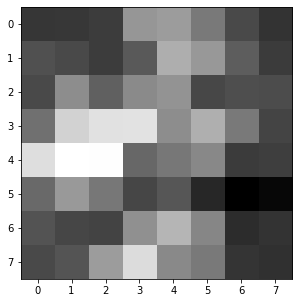

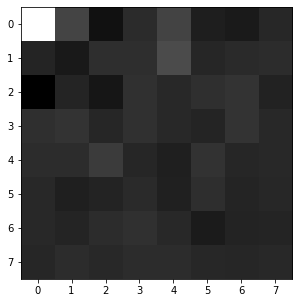

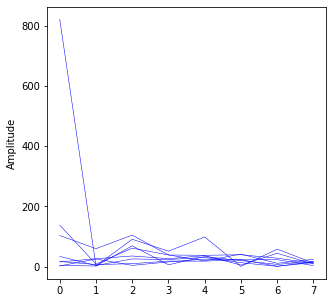

In [57]:
# Imagem de qualquer tamanho, nas extensões mais comuns (ex: .jpg, .jpeg, .png)
input_image('1.jpg')
dct2d_sep(img)
plot(imgDCT)
filter(imgDCT, opt=2)
create_chords(imgDCT)
